In [178]:
import librosa
import copy
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy.signal as signal
from tabulate import tabulate

In [179]:
# Global parameters used in preprocessing

PREFIXES = ["test_data/neutral/neutral_", "test_data/forced/forced_"]
FILENAMES = ["angry", "disgusted", "happy", "surprised"]
NUM_CHANNELS = 3
UNWANTED_CHANNELS = []

NFFT = 128
SAMPLE_RATE = 1152
LOW_CUTOFF = 10
HIGH_CUTOFF = 450

In [180]:
# Open the .txt containing the sensor output
# and then store the values for plotting
raw_data = []

for file_id, filename in enumerate(FILENAMES):
  a = []
  for prefix_id, prefix in enumerate(PREFIXES):
    # print(f"{prefix}{filename}.txt")
    with open(f"{prefix}{filename}.txt", "r") as f:
      temp = f.read().splitlines()
      num_points = len(temp)
      temp_data = np.zeros((NUM_CHANNELS, num_points))
      for c, t in enumerate(temp):
        split = t.split(',')
        for i in range(NUM_CHANNELS):
          temp_data[i][c] = split[i]
      a.append((len(temp_data), temp_data))
  
  max_points = max(i[0] for i in a)
  for data in a:
    np.resize(data[1], (NUM_CHANNELS, max_points))
  raw_data.append([i[1] for i in a])

####################################
# The shape of the data format is 3 dimensional:
#   1st dimension: emotion
#   2nd dimension: modality (voiced/silent)
#   3rd dimension: sEMG channels
####################################

In [181]:
print(f"There are {len(raw_data)} entries that are being compared between {len(PREFIXES)} modalities:")

table = []
for i in range(len(raw_data)):
    table.append([FILENAMES[i], len(raw_data[i][0][0]), len(raw_data[i][1][0])])

print(tabulate(table, headers=["Emotion", "Voiced data points", "Silent data points"]))

There are 4 entries that are being compared between 2 modalities:
Emotion      Voiced data points    Silent data points
---------  --------------------  --------------------
angry                     41046                 40888
disgusted                 39271                 40113
happy                     40219                 39744
surprised                 41095                 40630


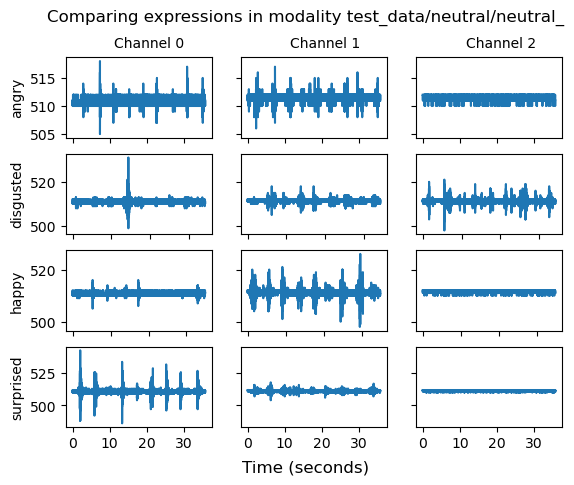

In [182]:
plot_data = raw_data
MODALITY = 0

fig, axs = plt.subplots(len(FILENAMES), 3, sharey="row")
fig.suptitle(f"Comparing expressions in modality {PREFIXES[MODALITY]}")
fig.supxlabel("Time (seconds)")

for c, i in enumerate(plot_data):
  axs[c, 0].set_ylabel(FILENAMES[c])
  for d, j in enumerate(i[MODALITY]):
    time_axis = np.linspace(0, len(j) / SAMPLE_RATE, len(j))
    axs[c, d].plot(time_axis, j)

for ax in axs.flat:
  ax.label_outer()
  ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

fig.text(0.2, 0.9, "Channel 0")
fig.text(0.475, 0.9, "Channel 1")
fig.text(0.75, 0.9, "Channel 2")

plt.show()

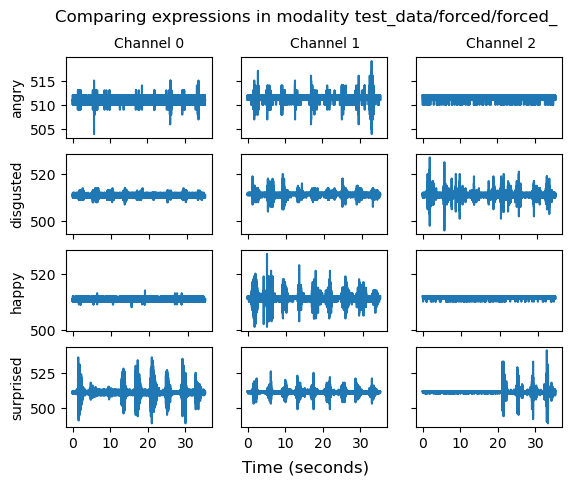

In [183]:
plot_data = raw_data
MODALITY = 1

fig, axs = plt.subplots(len(FILENAMES), 3, sharey="row")
fig.suptitle(f"Comparing expressions in modality {PREFIXES[MODALITY]}")
fig.supxlabel("Time (seconds)")

for c, i in enumerate(plot_data):
  axs[c, 0].set_ylabel(FILENAMES[c])
  for d, j in enumerate(i[MODALITY]):
    time_axis = np.linspace(0, len(j) / SAMPLE_RATE, len(j))
    axs[c, d].plot(time_axis, j)

for ax in axs.flat:
  ax.label_outer()
  ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

fig.text(0.2, 0.9, "Channel 0")
fig.text(0.475, 0.9, "Channel 1")
fig.text(0.75, 0.9, "Channel 2")

plt.show()

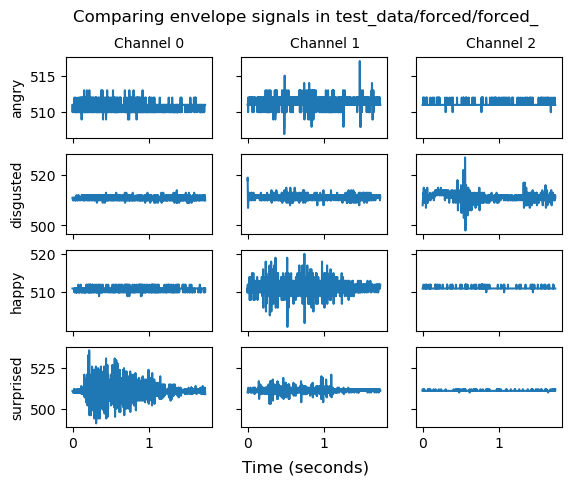

In [184]:
plot_data = raw_data
MODALITY = 1

fig, axs = plt.subplots(len(FILENAMES), 3, sharey="row")
fig.suptitle(f"Comparing envelope signals in {PREFIXES[MODALITY]}")
fig.supxlabel("Time (seconds)")

for c, i in enumerate(plot_data):
  axs[c, 0].set_ylabel(FILENAMES[c])
  for d, j in enumerate(i[MODALITY]):
    time_axis = np.arange(len(j[1500:3500])) / SAMPLE_RATE
    axs[c, d].plot(time_axis, j[1500:3500])

for ax in axs.flat:
  ax.label_outer()
  # ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

fig.text(0.2, 0.9, "Channel 0")
fig.text(0.475, 0.9, "Channel 1")
fig.text(0.75, 0.9, "Channel 2")

plt.show()

# Preprocess

In [185]:
# For every emotion
for i in raw_data:
  # For every modality
  for j in i:
    # For every channel
    for index, k in enumerate(j):
      # as you want your data to be between -1 and 1, everything should be scaled to 2, 
      # if your desired min and max are other values, replace 2 with your_max - your_min
      ratio = 2 / (np.max(k) - np.min(k)) 
      shift = (np.max(k) + np.min(k)) / 2
      # now you need to shift the center to the middle, this is not the average of the values.
      j[index] = (k - shift) * ratio 

In [186]:
def highpass_filter(data, cutoff, fs, order=5):
    # nyq = 0.5 * fs
    # normal_cutoff = cutoff / nyq
    # print(normal_cutoff)
    b, a = signal.butter(order, cutoff, fs=SAMPLE_RATE, btype='highpass', analog=False)
    y = signal.filtfilt(b, a, data)
    return y

def lowpass_filter(data, cutoff, fs, order=5):
    # nyq = 0.5 * fs
    # normal_cutoff = cutoff / nyq
    # print(normal_cutoff)
    b, a = signal.butter(order, cutoff, fs=SAMPLE_RATE, btype='lowpass', analog=False)
    y = signal.filtfilt(b, a, data)
    return y


In [187]:
# For every emotion
for i in raw_data:
  # For every modality
  for j in i:
    # For every channel
    for index, k in enumerate(j):
      temp = highpass_filter(k, LOW_CUTOFF, SAMPLE_RATE)
      j[index] = lowpass_filter(temp, HIGH_CUTOFF, SAMPLE_RATE)

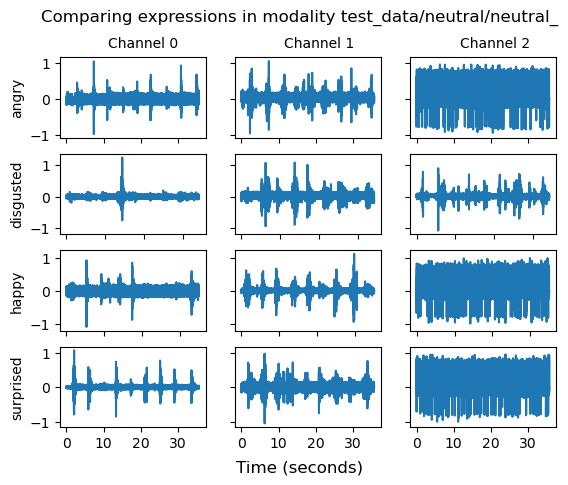

In [188]:
plot_data = raw_data
MODALITY = 0

fig, axs = plt.subplots(len(FILENAMES), 3, sharey="row")
fig.suptitle(f"Comparing expressions in modality {PREFIXES[MODALITY]}")
fig.supxlabel("Time (seconds)")

for c, i in enumerate(plot_data):
  axs[c, 0].set_ylabel(FILENAMES[c])
  for d, j in enumerate(i[MODALITY]):
    time_axis = np.linspace(0, len(j) / SAMPLE_RATE, len(j))
    axs[c, d].plot(time_axis, j)

for ax in axs.flat:
  ax.label_outer()
  ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

fig.text(0.2, 0.9, "Channel 0")
fig.text(0.475, 0.9, "Channel 1")
fig.text(0.75, 0.9, "Channel 2")

plt.show()

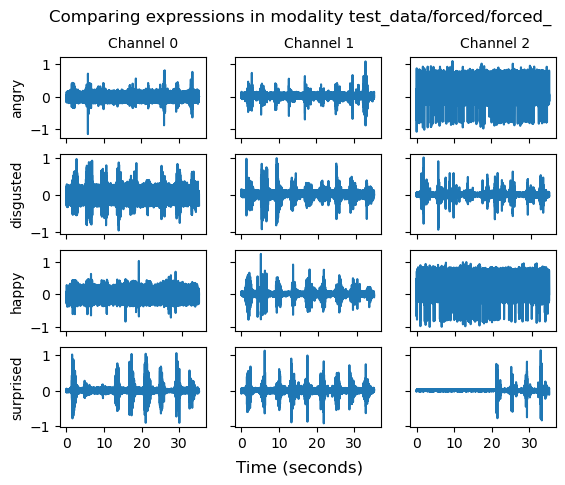

In [189]:
plot_data = raw_data
MODALITY = 1

fig, axs = plt.subplots(len(FILENAMES), 3, sharey="row")
fig.suptitle(f"Comparing expressions in modality {PREFIXES[MODALITY]}")
fig.supxlabel("Time (seconds)")

for c, i in enumerate(plot_data):
  axs[c, 0].set_ylabel(FILENAMES[c])
  for d, j in enumerate(i[MODALITY]):
    time_axis = np.linspace(0, len(j) / SAMPLE_RATE, len(j))
    axs[c, d].plot(time_axis, j)

for ax in axs.flat:
  ax.label_outer()
  ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

fig.text(0.2, 0.9, "Channel 0")
fig.text(0.475, 0.9, "Channel 1")
fig.text(0.75, 0.9, "Channel 2")

plt.show()

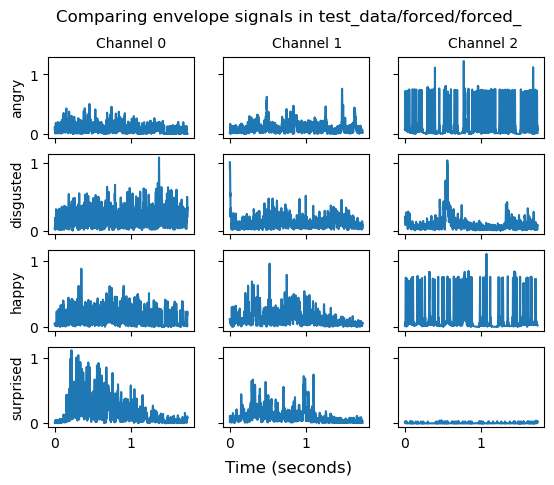

In [202]:
plot_data = envelope_data
MODALITY = 1

fig, axs = plt.subplots(len(FILENAMES), 3, sharey="row")
fig.suptitle(f"Comparing envelope signals in {PREFIXES[MODALITY]}")
fig.supxlabel("Time (seconds)")

for c, i in enumerate(plot_data):
  axs[c, 0].set_ylabel(FILENAMES[c])
  for d, j in enumerate(i[MODALITY]):
    time_axis = np.arange(len(j[1500:3500])) / SAMPLE_RATE
    axs[c, d].plot(time_axis, j[1500:3500])

for ax in axs.flat:
  ax.label_outer()
  # ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

fig.text(0.2, 0.9, "Channel 0")
fig.text(0.475, 0.9, "Channel 1")
fig.text(0.75, 0.9, "Channel 2")

plt.show()

# Calculating Cross-Correlation

In [190]:
MODE = "same"
CORRELATION_EMG_CHANNEL = 1
CORRELATION_EMG_MODALITY  = 0

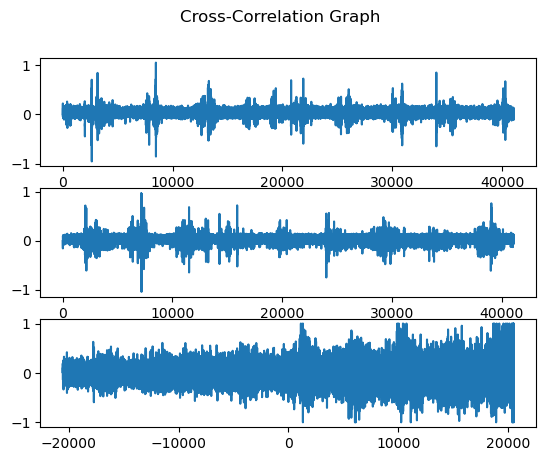

In [191]:
signal1 = raw_data[0][CORRELATION_EMG_MODALITY][CORRELATION_EMG_CHANNEL]
signal2 = raw_data[3][CORRELATION_EMG_MODALITY][CORRELATION_EMG_CHANNEL]

correlation_output = signal.correlate(signal1, signal2, mode=MODE, method="fft")
correlation_lags = signal.correlation_lags(len(signal1), len(signal2), mode=MODE)
# normalize correlation output
for i in range(len(correlation_output)):
  ratio = 2 / (np.max(correlation_output) - np.min(correlation_output)) 
  shift = (np.max(correlation_output) + np.min(correlation_output)) / 2
  correlation_output[i] = (correlation_output[i] - shift) * ratio 
# correlation_output /= np.max(correlation_output)

fig, axs = plt.subplots(3, 1)
fig.suptitle(f"Cross-Correlation Graph")
axs[0].plot(signal1)
axs[1].plot(signal2)
axs[2].plot(correlation_lags, correlation_output)
plt.show()

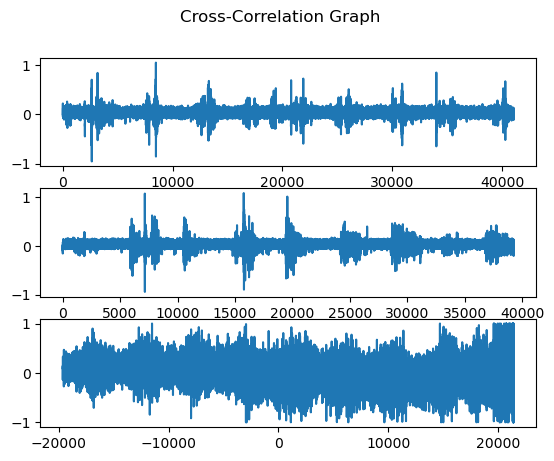

In [192]:
signal1 = raw_data[0][CORRELATION_EMG_MODALITY][CORRELATION_EMG_CHANNEL]
signal2 = raw_data[1][CORRELATION_EMG_MODALITY][CORRELATION_EMG_CHANNEL]

correlation_output = signal.correlate(signal1, signal2, mode=MODE, method="fft")
correlation_lags = signal.correlation_lags(len(signal1), len(signal2), mode=MODE)
# normalize correlation output
for i in range(len(correlation_output)):
  ratio = 2 / (np.max(correlation_output) - np.min(correlation_output)) 
  shift = (np.max(correlation_output) + np.min(correlation_output)) / 2
  correlation_output[i] = (correlation_output[i] - shift) * ratio 
# correlation_output /= np.max(correlation_output)

fig, axs = plt.subplots(3, 1)
fig.suptitle(f"Cross-Correlation Graph")
axs[0].plot(signal1)
axs[1].plot(signal2)
axs[2].plot(correlation_lags, correlation_output)
plt.show()

# Calculating Auto Correlation

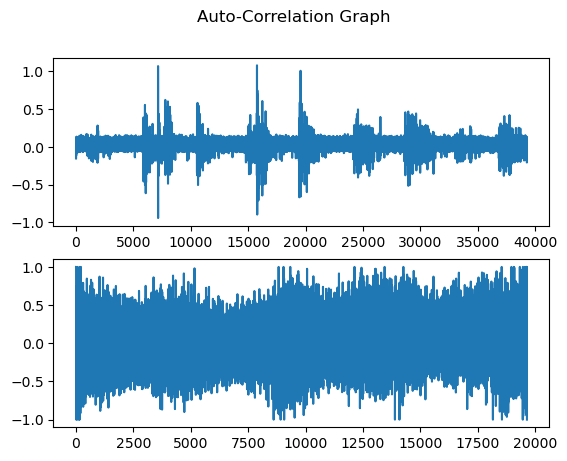

In [193]:
MODE = "same"
CORRELATION_EMG_CHANNEL = 1
CORRELATION_EMG_MODALITY  = 0

signal1 = raw_data[1][CORRELATION_EMG_MODALITY][CORRELATION_EMG_CHANNEL]

correlation_output = signal.correlate(signal1, signal1, mode=MODE, method="auto")
correlation_output = correlation_output[correlation_output.size // 2:]
correlation_lags = signal.correlation_lags(len(signal1), len(signal1), mode=MODE)

# normalize correlation output
for i in range(len(correlation_output)):
  ratio = 2 / (np.max(correlation_output) - np.min(correlation_output)) 
  shift = (np.max(correlation_output) + np.min(correlation_output)) / 2
  correlation_output[i] = (correlation_output[i] - shift) * ratio 

fig, axs = plt.subplots(2, 1)
fig.suptitle(f"Auto-Correlation Graph")
axs[0].plot(signal1)
axs[1].plot(correlation_lags[correlation_lags.size // 2:], correlation_output)
plt.show()

# Applying Envelope Detector

In [194]:
envelope_data = copy.deepcopy(raw_data)

# For every emotion
for i in envelope_data:
  # For every modality
  for j in i:
    # For every channel
    for index, k in enumerate(j):
      j[index] = np.abs(signal.hilbert(k))

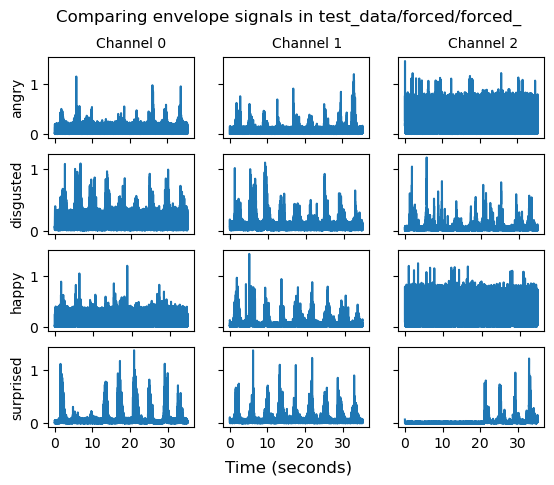

In [195]:
plot_data = envelope_data
MODALITY = 1

fig, axs = plt.subplots(len(FILENAMES), 3, sharey="row")
fig.suptitle(f"Comparing envelope signals in {PREFIXES[MODALITY]}")
fig.supxlabel("Time (seconds)")

for c, i in enumerate(plot_data):
  axs[c, 0].set_ylabel(FILENAMES[c])
  for d, j in enumerate(i[MODALITY]):
    time_axis = np.arange(len(j)) / SAMPLE_RATE
    axs[c, d].plot(time_axis, j)

for ax in axs.flat:
  ax.label_outer()
  ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

fig.text(0.2, 0.9, "Channel 0")
fig.text(0.475, 0.9, "Channel 1")
fig.text(0.75, 0.9, "Channel 2")

plt.show()

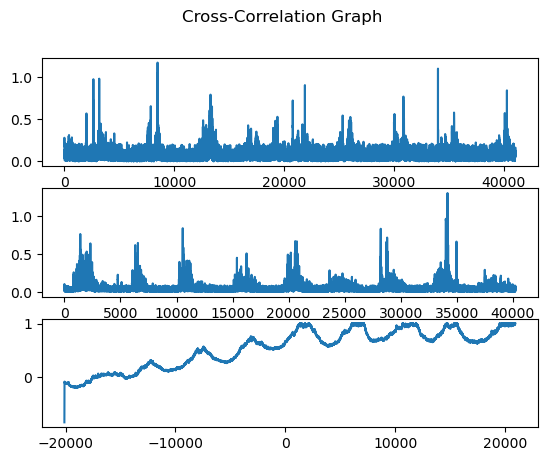

In [196]:
MODE = "same"
CORRELATION_EMG_CHANNEL = 1
CORRELATION_EMG_MODALITY  = 0

signal1 = envelope_data[0][CORRELATION_EMG_MODALITY][CORRELATION_EMG_CHANNEL]
signal2 = envelope_data[2][CORRELATION_EMG_MODALITY][CORRELATION_EMG_CHANNEL]

correlation_output = signal.correlate(signal1, signal2, mode=MODE, method="fft")
correlation_lags = signal.correlation_lags(len(signal1), len(signal2), mode=MODE)
# normalize correlation output
for i in range(len(correlation_output)):
  ratio = 2 / (np.max(correlation_output) - np.min(correlation_output)) 
  shift = (np.max(correlation_output) + np.min(correlation_output)) / 2
  correlation_output[i] = (correlation_output[i] - shift) * ratio 
# correlation_output /= np.max(correlation_output)

fig, axs = plt.subplots(3, 1)
fig.suptitle(f"Cross-Correlation Graph")
axs[0].plot(signal1)
axs[1].plot(signal2)
axs[2].plot(correlation_lags, correlation_output)
plt.show()

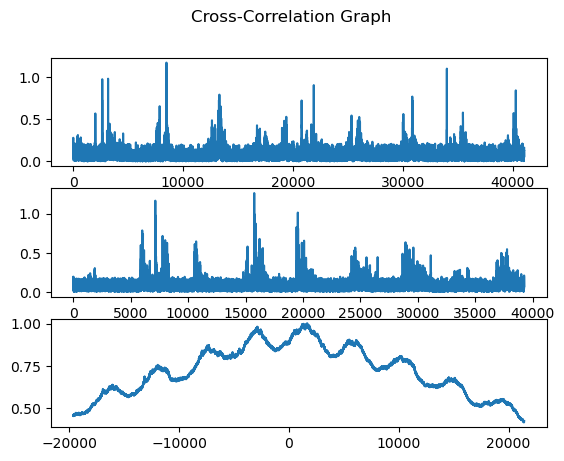

In [204]:
MODE = "same"
CORRELATION_EMG_CHANNEL = 1
CORRELATION_EMG_MODALITY  = 0

signal1 = envelope_data[0][CORRELATION_EMG_MODALITY][CORRELATION_EMG_CHANNEL]
signal2 = envelope_data[1][CORRELATION_EMG_MODALITY][CORRELATION_EMG_CHANNEL]

correlation_output = signal.correlate(signal1, signal2, mode=MODE, method="fft")
correlation_lags = signal.correlation_lags(len(signal1), len(signal2), mode=MODE)
# normalize correlation output
# for i in range(len(correlation_output)):
#   ratio = 2 / (np.max(correlation_output) - np.min(correlation_output)) 
#   shift = (np.max(correlation_output) + np.min(correlation_output)) / 2
#   correlation_output[i] = (correlation_output[i] - shift) * ratio 
correlation_output /= np.max(correlation_output)

fig, axs = plt.subplots(3, 1)
fig.suptitle(f"Cross-Correlation Graph")
axs[0].plot(signal1)
axs[1].plot(signal2)
axs[2].plot(correlation_lags, correlation_output)
plt.show()

In [198]:
print(max(correlation_output))

319.63789470331056


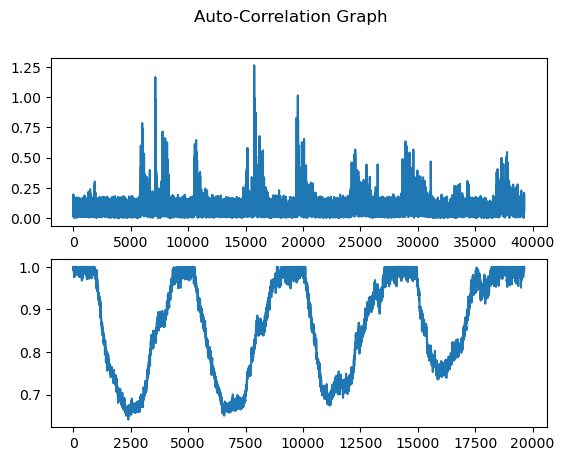

In [199]:
MODE = "same"
CORRELATION_EMG_CHANNEL = 1
CORRELATION_EMG_MODALITY  = 0

signal1 = envelope_data[1][CORRELATION_EMG_MODALITY][CORRELATION_EMG_CHANNEL]

correlation_output = signal.correlate(signal1, signal1, mode=MODE, method="auto")
correlation_output = correlation_output[correlation_output.size // 2:]
correlation_lags = signal.correlation_lags(len(signal1), len(signal1), mode=MODE)

# normalize correlation output
for i in range(len(correlation_output)):
  ratio = 2 / (np.max(correlation_output) - np.min(correlation_output)) 
  shift = (np.max(correlation_output) + np.min(correlation_output)) / 2
  correlation_output[i] = (correlation_output[i] - shift) * ratio 

fig, axs = plt.subplots(2, 1)
fig.suptitle(f"Auto-Correlation Graph")
axs[0].plot(signal1)
axs[1].plot(correlation_lags[correlation_lags.size // 2:], correlation_output)
plt.show()

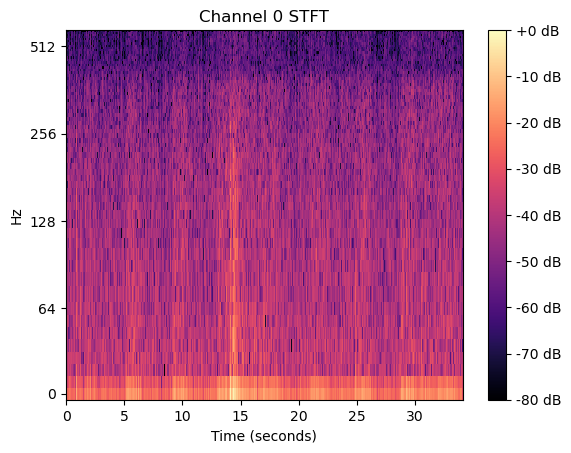

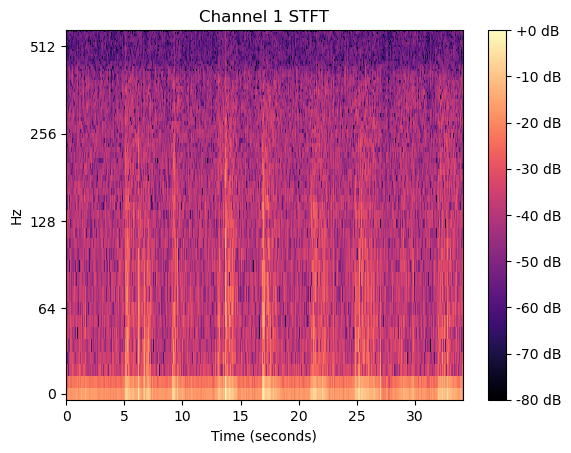

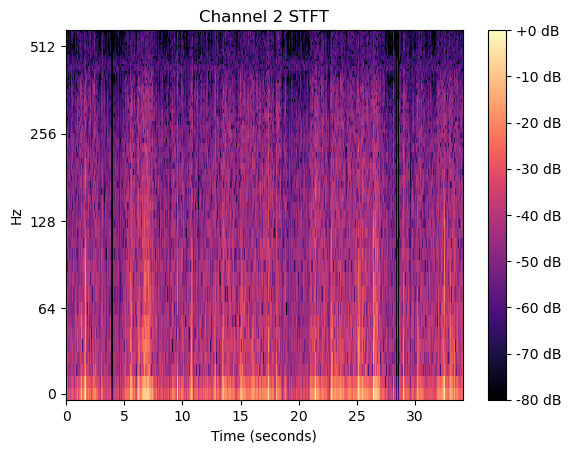

In [200]:
stft_channels = []
for idx, filtered_channel in enumerate(envelope_data[1][CORRELATION_EMG_MODALITY]):
  stft_channels.append(librosa.stft(filtered_channel, n_fft=NFFT))

# Plot STFT results
for idx, stft_result in enumerate(stft_channels):
  fig, ax = plt.subplots()
  img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_result),
                                                        ref=np.max),
                                y_axis='log', x_axis='s', ax=ax, sr=SAMPLE_RATE,
                                  n_fft=NFFT, hop_length=NFFT/4)
  ax.set_title(f"Channel {idx} STFT")
  fig.colorbar(img, ax=ax, format="%+2.0f dB")
  plt.show()

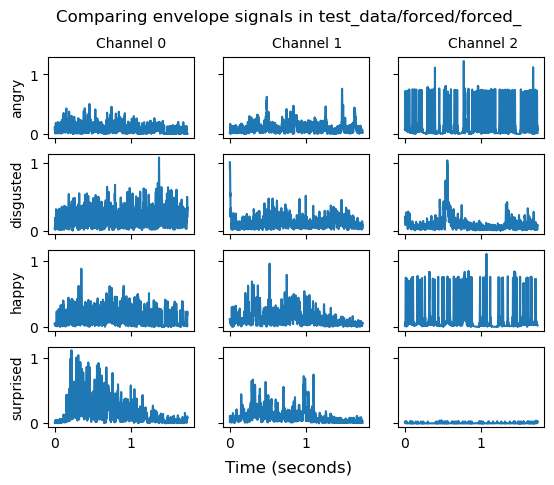

In [201]:
plot_data = envelope_data
MODALITY = 1

fig, axs = plt.subplots(len(FILENAMES), 3, sharey="row")
fig.suptitle(f"Comparing envelope signals in {PREFIXES[MODALITY]}")
fig.supxlabel("Time (seconds)")

for c, i in enumerate(plot_data):
  axs[c, 0].set_ylabel(FILENAMES[c])
  for d, j in enumerate(i[MODALITY]):
    time_axis = np.arange(len(j[1500:3500])) / SAMPLE_RATE
    axs[c, d].plot(time_axis, j[1500:3500])

for ax in axs.flat:
  ax.label_outer()
  # ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

fig.text(0.2, 0.9, "Channel 0")
fig.text(0.475, 0.9, "Channel 1")
fig.text(0.75, 0.9, "Channel 2")

plt.show()